In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Wrangling and Transforming

We begin by taking a peek at the contents of the file. To do this, we open the file and examine the first few rows ({numref}`Chapter %s <ch:files>`).

In [2]:
from pathlib import Path

# Create a Path pointing to our data file
insp_path = Path() / 'data' / 'donkeys.csv'

with insp_path.open() as f:
    # Display first five lines of file
    for _ in range(5):
        print(f.readline(), end='')

BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
3,<2,stallion,78,90,90,77,NA
2.5,<2,stallion,91,97,94,100,NA
1.5,<2,stallion,74,93,95,74,NA
3,<2,female,87,109,96,116,NA


We see that indeed the file is CSV formatted so we easily read it into a data frame.

In [3]:
donkeys = pd.read_csv("donkeys.csv")
donkeys.head()

,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
0,3.0,<2,stallion,78,90,90,77,NaN
1,2.5,<2,stallion,91,97,94,100,NaN
2,1.5,<2,stallion,74,93,95,74,NaN
3,3.0,<2,female,87,109,96,116,NaN
4,2.5,<2,female,79,98,91,91,NaN


We check the data frame shape.

In [4]:
donkeys.shape

(544, 8)

According to the documentation, the granularity is a donkey ({numref}`Capter %s <ch:wrangling>`). The table below provides descriptions of  the eight features, as well as their data type, feature type, unit of measurement, and categories, as appropriate. 

:::{table} Donkey Study Codebook
:name: donkey-codebook

| Feature        | Data Type | Feature Type      | Description                                                        |
|----------------|-----------|------------|--------------------------------------------------------|
|BCS    | float64 |  ordinal | Body Condition Score: from 1 (emaciated) through 3 (healthy) to 5 (obese) in increments of 0.5. |
| Age          | string |  ordinal | Age in years, under 2, 2-5, 5-10, 10-15, 15-20, and over 20 years. |
| Sex          | string | nominal | Sex categories: stallion, gelding, female.  |
| Length      | int64 | numeric | body length (cm) from front leg elbow to back of pelvis. |
| Girth       | int64 | numeric | body circumference (cm), measured just behind front legs. |
| Height | int64 | numeric | body height (cm) up to point where neck connects to back.     |
| Weight    |int64   | numeric | weight (kilogram).   |
| WeightAlt  |float64  | numeric | second weight measurement taken on a small subset of donkeys.  |

:::



Figure X is a stylized representation of a donkey as a cylinder with neck and head and legs appended. Notice the height measurement includes the legs and body, and the girth and length are the circumference and length of the cylinder, respectively.   

Our next step is to perform some quality checks on the data. In the previous section, we listed a few potential quality concerns based on scope. Next, we check the quality of the measurements and their distributions.

Let's start with comparing the two weight measurements to check on the consistency of the scale. Below is a histogram of the difference between these two measurements for the small subset of donkeys that were weighed twice. 

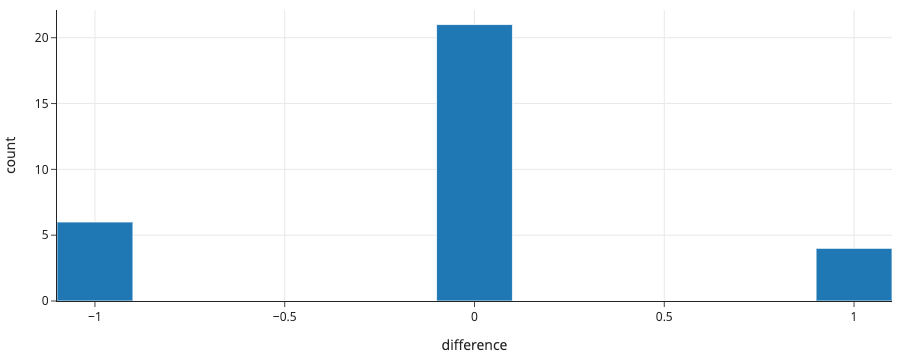

In [5]:
donkeys['difference'] = donkeys['WeightAlt'] - donkeys['Weight']

fig = px.histogram(donkeys, x='difference', nbins=20,
                      width=350, height=250)

fig

The measurements are all within 1 kg of each other, and the majority are exactly the same (to the nearest kilogram).

Next, we look for unusual values in the body condition score. 

In [8]:
donkeys['BCS'].value_counts()

3.0    307
2.5    135
3.5     55
      ... 
1.5      5
4.5      1
1.0      1
Name: BCS, Length: 8, dtype: int64

Let's examine the entire record for the donkeys with the lowest and highest body condition score.

In [7]:
donkeys[ (donkeys['BCS'] == 1.0) | (donkeys['BCS'] == 4.5) ]

,BCS,Age,Sex,Length,...,Height,Weight,WeightAlt,difference
291,4.5,10-15,female,107,...,106,227,NaN,NaN
445,1.0,>20,female,97,...,102,115,NaN,NaN


Since there is only one donkey with a body condition score of 1 (emaciated) and one donkey with a score of 4.5 (obese), and these values are at the extremes of the measurements, we are cautious about including them in our study. We remove these two records, and keep in mind that we may also decide to remove the five donkeys with a score of 1.5, if they appear anomalous in our later analysis. 

In [8]:
donkeys = donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4) ]

Next, we examine the distribution of values for weight to see if there are any issues with quality. 

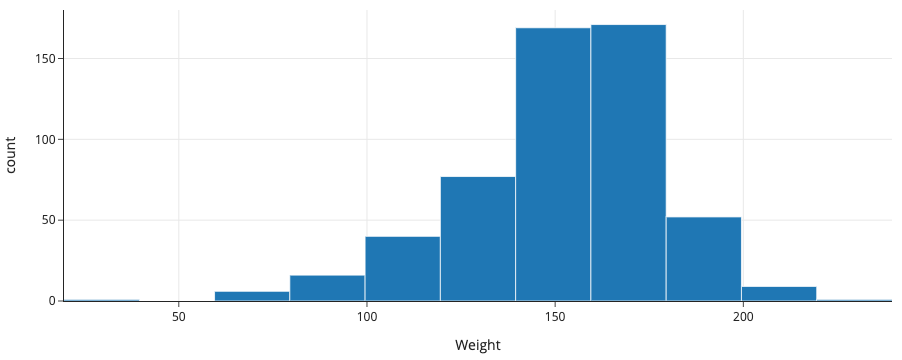

In [9]:
fig = px.histogram(donkeys, x='Weight', nbins=20,
                      width=350, height=250)
fig

It appears that there is one very light donkey. This observation may unduly influence any model fitting. We check the relationship between weight and height to assess the quality of the data for analysis.

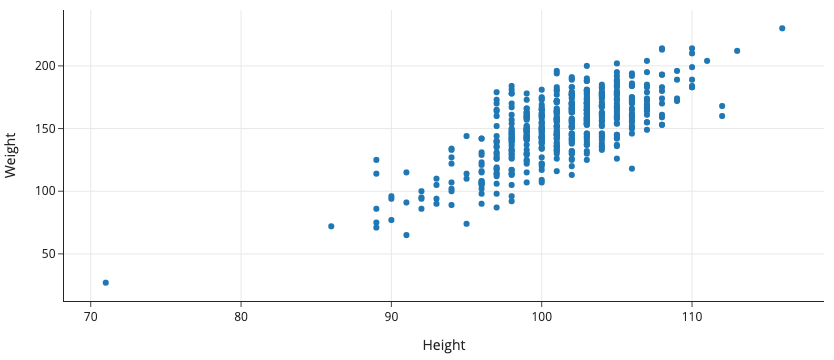

In [10]:

fig = px.scatter(donkeys, x='Height', y='Weight',
                 width=350, height=250)
fig

The small donkey is far from the main concentration of donkeys and would overly influence any model. For this reason, we exclude it. Again, we keep in mind that we may also want to exclude the one or two heavy donkeys, if they appear to overly influence our future model fitting. 

In [11]:
donkeys = donkeys[(donkeys['Weight'] >= 40)]

In [12]:
donkeys.shape

(541, 9)

Based on our cleaning and quality checks, we removed three anomalous observations from the data frame. Now, we're ready to begin our exploratory analysis. But, before we proceed, we divide our data into an 80/20 split. We use 80\% of our data to explore and build our model, and then evaluate the model with the 20\% that has been set aside. 

In [13]:
indices = np.arange(len(donkeys))
np.random.seed(42)
np.random.shuffle(indices)
n_train = int(np.round((len(donkeys)*0.8)))

We have simply taken a random shuffle of the indices for the data frame.
Next, we assign the first 80\% to the training data frame and the remaining 20% to the test set.   

In [14]:
train_set = donkeys.iloc[indices[ :n_train], ]
test_set = donkeys.iloc[indices[ n_train:], ]

We confirm that the test and train sets are the expected shape.

In [15]:
train_set.shape

(433, 9)

In [16]:
test_set.shape

(108, 9)

Now we are ready to explore the training data to uncover potentially useful relationships and distributions that inform our modeling. 